## Predicting Survivors on Kaggle Competion on Titanic
### https://www.kaggle.com/c/titanic/

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [62]:
# Following data files were downloaded from respective Kaggle competition

train_data = pd.read_csv("train.csv")                           # 891 rows
test_data = pd.read_csv("test.csv")                             # 418 rows
gender_submission_data = pd.read_csv("gender_submission.csv")   # 418 rows

In [63]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [64]:
# Checks for na in train data
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [65]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [66]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [67]:
# Cabin collumn was revmoved because around 80% of data is missing from both test and training data.
# Columns PassengerId, Name, ticket, Fare and Embarked were also removed considering not relevant for prediction
train_data.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1, inplace=True)
test_data.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1, inplace=True)

In [68]:
# categorical data was encoded
# train_data.replace({"Sex": {"male": 1, "female": 0}}, inplace=True)
# test_data.replace({"Sex": {"male": 1, "female": 0}}, inplace=True)

In [69]:
# Now, the train_data looks like this.
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0
...,...,...,...,...,...,...
886,0,2,male,27.0,0,0
887,1,1,female,19.0,0,0
888,0,3,female,NaN,1,2
889,1,1,male,26.0,0,0


In [70]:
# Also, it was observed that around 20% of age information is missing from samples of both training and test data.
# But instead of just removing the samples with 'na' data for age, let's try to find different options available
# to replace the missing age data. Let's first see factors could affect age.

In [71]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

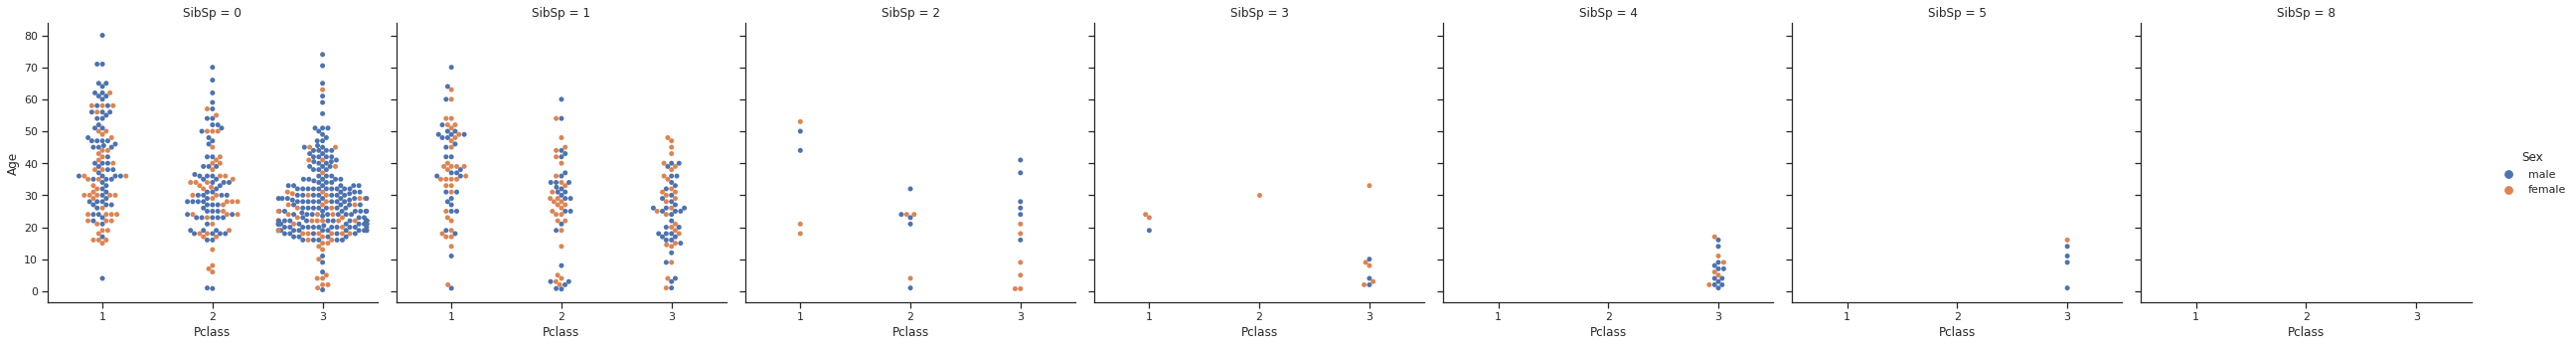

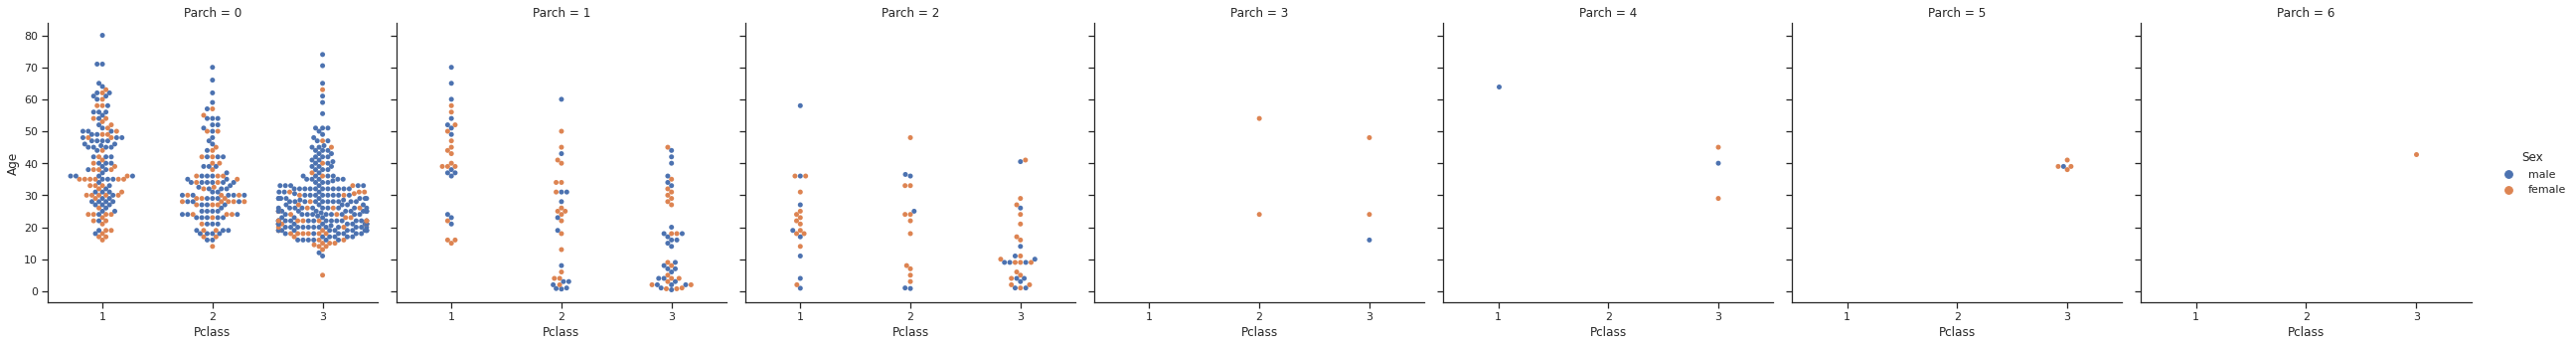

In [73]:
sns.catplot(x="Pclass", y="Age", hue="Sex", kind="swarm", col="SibSp", data=train_data);
sns.catplot(x="Pclass", y="Age", hue="Sex", kind="swarm", col="Parch", data=train_data);

In [74]:
# It is seen that Pclass, SibSp, Parch, and Sex to some extent influence passenger's age.
# As XGBoost has built-in feature to handle missing value, let's first see how it works.
# If it doesn't work well, then a model will then be built to predict and fill in the
# missing ages.

In [75]:
# Now, performs one hot encoding on Pclass and Sex which are categorical data
train_data = pd.concat([train_data, pd.get_dummies(train_data.Pclass, prefix="Pclass")], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data.Pclass, prefix="Pclass")], axis=1)

train_data = pd.concat([train_data, pd.get_dummies(train_data.Sex, prefix="Sex")], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data.Sex, prefix="Sex")], axis=1)

# Removes column Pclass, Sex as these are no more required after one hot encoding
train_data.drop(["Pclass"], axis=1, inplace=True)
test_data.drop(["Pclass"], axis=1, inplace=True)

train_data.drop(["Sex"], axis=1, inplace=True)
test_data.drop(["Sex"], axis=1, inplace=True)

In [76]:
# Now, the train data looks like this.
train_data

,Survived,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,1,0,0,0,1,0,1
1,1,38.0,1,0,1,0,0,1,0
2,1,26.0,0,0,0,0,1,1,0
3,1,35.0,1,0,1,0,0,1,0
4,0,35.0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,0,1,0,0,1
887,1,19.0,0,0,1,0,0,1,0
888,0,NaN,1,2,0,0,1,1,0
889,1,26.0,0,0,1,0,0,0,1


In [77]:
test_data

,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,34.5,0,0,0,0,1,0,1
1,47.0,1,0,0,0,1,1,0
2,62.0,0,0,0,1,0,0,1
3,27.0,0,0,0,0,1,0,1
4,22.0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...
413,NaN,0,0,0,0,1,0,1
414,39.0,0,0,1,0,0,1,0
415,38.5,0,0,0,0,1,0,1
416,NaN,0,0,0,0,1,0,1


In [78]:
from sklearn.model_selection import train_test_split

In [79]:
# Seperates the target column from train data and splits the data with 20% as validation data

x_train = train_data
y_train = x_train.pop("Survived")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

In [80]:
model = xgb.XGBClassifier()

In [81]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

[0]	validation_0-error:0.178771
[1]	validation_0-error:0.178771
[2]	validation_0-error:0.162011
[3]	validation_0-error:0.162011
[4]	validation_0-error:0.162011
[5]	validation_0-error:0.162011
[6]	validation_0-error:0.162011
[7]	validation_0-error:0.162011
[8]	validation_0-error:0.162011
[9]	validation_0-error:0.162011
[10]	validation_0-error:0.162011
[11]	validation_0-error:0.162011
[12]	validation_0-error:0.162011
[13]	validation_0-error:0.162011
[14]	validation_0-error:0.162011
[15]	validation_0-error:0.162011
[16]	validation_0-error:0.162011
[17]	validation_0-error:0.162011
[18]	validation_0-error:0.162011
[19]	validation_0-error:0.162011
[20]	validation_0-error:0.162011
[21]	validation_0-error:0.162011
[22]	validation_0-error:0.162011
[23]	validation_0-error:0.162011
[24]	validation_0-error:0.162011
[25]	validation_0-error:0.162011
[26]	validation_0-error:0.162011
[27]	validation_0-error:0.162011
[28]	validation_0-error:0.162011
[29]	validation_0-error:0.162011
[30]	validation_0-er

XGBClassifier()

In [82]:
# With validation error noted from the traning, let's combine validation back with training data and
# perform retraiing to final model.

x_train = pd.concat([x_train, x_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [83]:
print(x_train.shape, y_train.shape)

(891, 8) (891,)


In [84]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

In [85]:
y_pred = model.predict(test_data)

In [86]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [87]:
gender_submission_data.drop(["Survived"], axis=1, inplace=True)

In [88]:
gender_submission_data.shape

(418, 1)

In [89]:
gender_submission_data["Survived"] = pd.Series(y_pred, name="Survived")

In [90]:
gender_submission_data.to_csv("Predictions.csv", index=False)